### Design the full graph using 3 tools: search_tool, RAG tool and SQL-agent for travel database

In [1]:
import os
from dotenv import load_dotenv
from pyprojroot import here
load_dotenv()

True

In [2]:
os.environ['OPENAI_API_KEY'] = os.getenv("OPEN_AI_API_KEY")
os.environ['TAVILY_API_KEY'] = os.getenv("TAVILY_API_KEY")

### 1. Initialize The Tools

#### 1.1 RAG tool designe

In [3]:
from langchain_chroma import Chroma
from langchain_ollama import OllamaEmbeddings
from langchain_core.tools import tool

EMBEDDING_MODEL = "nomic-embed-text"
VECTORDB_DIR = "data/airline_policy_vectordb"
K = 2

@tool
def lookup_policy(query: str)->str:
    """Consult the company policies to check whether certain options are permitted."""
    vectordb = Chroma(
    collection_name="rag-chroma",
    persist_directory=str(here(VECTORDB_DIR)),
    embedding_function=OllamaEmbeddings(model=EMBEDDING_MODEL)
    )
    docs = vectordb.similarity_search(query, k=K)
    return "\n\n".join([doc.page_content for doc in docs])

print(lookup_policy)

name='lookup_policy' description='Consult the company policies to check whether certain options are permitted.' args_schema=<class 'langchain_core.utils.pydantic.lookup_policy'> func=<function lookup_policy at 0x76ad386d5f80>


Test the RAG tool

In [4]:
lookup_policy.invoke("can I cancel my ticket?")

'for a refund or may only be able to receive a partial refund. If you booked your flight through a third-party website or\ntravel agent, you may need to contact them directly to cancel your flight. Always check the terms and conditions of your\nticket to make sure you understand the cancellation policy and any associated fees or penalties. If you\'re cancelling your\nflight due to unforeseen circumstances such as a medical emergency or a natural disaster , Swiss Air may of fer you\nspecial exemptions or accommodations. What is Swiss Airlines 24 Hour Cancellation Policy? Swiss Airlines has a 24\n\ncircumstances such as bad weather or political unrest, Swiss Airlines may not be obligated to of fer any compensation. In\nsummary , Swiss Airlines\' cancellation policy varies depending on your fare type and the time of cancellation. T o avoid any\nunnecessary fees or charges, it\'s important to familiarise yourself with the terms and conditions of your ticket and to\ncontact Swiss Airlines a

#### 1.2 Search tool designe

In [5]:
from langchain_community.tools.tavily_search import TavilySearchResults

search_tool = TavilySearchResults(max_results=2)

Test the Search Tools

In [6]:
search_tool.invoke("What's a 'node' in LangGraph?")

[{'url': 'https://langchain-ai.github.io/langgraph/concepts/low_level/',
  'content': 'Nodes¶ In LangGraph, nodes are typically python functions (sync or async) where the first positional argument is the state, and (optionally), the second positional argument is a "config", containing optional configurable parameters (such as a thread_id). Similar to NetworkX, you add these nodes to a graph using the add_node method:'},
 {'url': 'https://medium.com/@cplog/introduction-to-langgraph-a-beginners-guide-14f9be027141',
  'content': 'Nodes: Nodes are the building blocks of your LangGraph. Each node represents a function or a computation step. You define nodes to perform specific tasks, such as processing input, making'}]

#### 1.3 SQL agent tool designe

In [7]:
from langchain_community.utilities import SQLDatabase
from langchain.chains import create_sql_query_chain
from langchain_community.tools.sql_database.tool import QuerySQLDatabaseTool
from langchain_community.tools.sql_database.tool import QuerySQLDataBaseTool
from langchain_core.prompts import PromptTemplate
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnablePassthrough
from operator import itemgetter
from langchain_ollama import ChatOllama
from langchain import hub
from typing_extensions import TypedDict
from typing_extensions import Annotated

In [27]:
class State(TypedDict):
    question: str
    query: str
    result: str
    answer: str

class QueryOutput(TypedDict):
    """Generated SQL query."""

    query: Annotated[str, ..., "Syntactically valid SQL query."]


query_prompt_template = hub.pull("langchain-ai/sql-query-system-prompt")

sqldb_directory = here("data/Chinook.db")
db = SQLDatabase.from_uri(
    f"sqlite:///{sqldb_directory}")

llm = ChatOllama(model="qwen2.5:14b", temperature=0)

execute_query = QuerySQLDatabaseTool(db=db)

answer_prompt = PromptTemplate.from_template(
    """Given the following user question, corresponding SQL query, and SQL result, answer the user question in a funny way.

Question: {question}
SQL Query: {query}
SQL Result: {result}
Answer: """
)    

def write_query(state: State):
    prompt = query_prompt_template.invoke({
        "dialect": db.dialect,
        "top_k": 10,
        "table_info": db.get_table_info(),
        "input": state["question"],
    })
    structured_llm = llm.with_structured_output(QueryOutput)
    result = structured_llm.invoke(prompt)
    return result

answer = answer_prompt | llm | StrOutputParser()
# Build the chain
chain = (
    RunnablePassthrough.assign(query=write_query).assign(
        result=itemgetter("query") | execute_query
    )
    | answer
)

@tool
def query_sqldb(query):
    """Query the Swiss Airline SQL Database and access all the company's information. Input should be a search query."""
    response = chain.invoke({"question": query})
    return response

In [28]:
message = "How many employees are there"
# message = "How many tables do I have in the database? and what are their names?"
response = query_sqldb.invoke(message)
print(response)

Ah, I see you're curious about our little office family! Well, if numbers could talk and these told me a story, they'd say there's a grand total of eight employees in our merry band. So, to answer your question directly (and perhaps a bit more formally than needed): the employee count is 8. But hey, who needs words when you can just picture eight tiny dancing figures with top hats and canes? Enjoy your day, and remember, every employee makes the world go 'round... or at least our office does!


Wrap up the tools into a list

In [43]:
tools = [search_tool, lookup_policy, query_sqldb]

#### Load the LLM for the primary agent and bind it with the tools

In [44]:
llm = ChatOllama(model="qwen2.5:14b", temperature=0)
# Tell the LLM which tools it can call
llm_with_tools = llm.bind_tools(tools)

### 2. Initialize the Graph State

Define our StateGraph's state as a typed dictionary containing an append-only list of messages. These messages form the chat history, which is all the state our chatbot needs.

In [45]:
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START
from langgraph.graph.message import add_messages


class StateG(TypedDict):
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(StateG)

### 3. Define the Graph Nodes

#### 3.1 First node: chatbot

In [46]:
def chatbot(state: StateG):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}


graph_builder.add_node("chatbot", chatbot)

Next, we need to create a function that will run the tools when they are needed. To do this, we'll add the tools to a new node.

In the example below, we'll build a BasicToolNode. This node will check the latest message and, if it contains a request to use a tool, it will run the appropriate tool. This works because many language models (like Anthropic, OpenAI, and Google Gemini) support tool usage.

#### 3.2 Second node: BasicToolNode that runs the appropriate tool based on the primary agent's output

In [47]:
import json
from langchain_core.messages import ToolMessage


class BasicToolNode:
    """A node that runs the tools requested in the last AIMessage."""

    def __init__(self, tools: list) -> None:
        self.tools_by_name = {tool.name: tool for tool in tools}

    def __call__(self, inputs: dict):
        if messages := inputs.get("messages", []):
            message = messages[-1]
        else:
            raise ValueError("No message found in input")
        outputs = []
        for tool_call in message.tool_calls:
            tool_result = self.tools_by_name[tool_call["name"]].invoke(
                tool_call["args"]
            )
            outputs.append(
                ToolMessage(
                    content=json.dumps(tool_result),
                    name=tool_call["name"],
                    tool_call_id=tool_call["id"],
                )
            )
        return {"messages": outputs}


tool_node = BasicToolNode(tools=[search_tool, lookup_policy, query_sqldb])
graph_builder.add_node("tools", tool_node)

### 4. Define the entry point and graph edges

Approach 1

In [48]:
from typing import Literal


def route_tools(
    state: StateG,
) -> Literal["tools", "__end__"]:
    """
    Use in the conditional_edge to route to the ToolNode if the last message
    has tool calls. Otherwise, route to the end.
    """
    if isinstance(state, list):
        ai_message = state[-1]
    elif messages := state.get("messages", []):
        ai_message = messages[-1]
    else:
        raise ValueError(f"No messages found in input state to tool_edge: {state}")
    if hasattr(ai_message, "tool_calls") and len(ai_message.tool_calls) > 0:
        return "tools"
    return "__end__"


# The `tools_condition` function returns "tools" if the chatbot asks to use a tool, and "__end__" if
# it is fine directly responding. This conditional routing defines the main agent loop.
graph_builder.add_conditional_edges(
    "chatbot",
    route_tools,
    # The following dictionary lets you tell the graph to interpret the condition's outputs as a specific node
    # It defaults to the identity function, but if you
    # want to use a node named something else apart from "tools",
    # You can update the value of the dictionary to something else
    # e.g., "tools": "my_tools"
    {"tools": "tools", "__end__": "__end__"},
)
# Any time a tool is called, we return to the chatbot to decide the next step
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")

Approach 2

In [49]:
from langgraph.graph import END, MessagesState
from typing import Literal

# Define the function that determines whether to continue or not
def should_continue(state: MessagesState) -> Literal["tools", END]:
    messages = state['messages']
    last_message = messages[-1]
    # If the LLM makes a tool call, then we route to the "tools" node
    if last_message.tool_calls:
        return "tools"
    # Otherwise, we stop (reply to the user)
    return END

graph_builder.add_conditional_edges(
    "chatbot",
    should_continue,
    ["tools", END],
)
# Any time a tool is called, we return to the chatbot to decide the next step
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")

### 5. Compile the graph

In [50]:
from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()
graph = graph_builder.compile(checkpointer=memory)

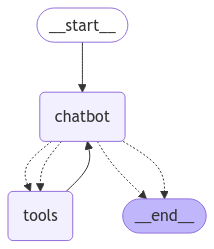

In [51]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [52]:
save = False

if save:
    from PIL import Image as PILImage
    import io
    # Assuming graph.get_graph().draw_mermaid_png() returns PNG binary data
    try:
        # Generate the PNG image from the graph
        png_data = graph.get_graph().draw_mermaid_png()
        
        # Convert the binary data into an image
        img = PILImage.open(io.BytesIO(png_data))
        
        # Save the image locally with 300 DPI
        img.save('output_image.png', 'PNG', dpi=(300, 300))
        
        print("Image saved successfully with 300 DPI.")
    except Exception as e:
        print(f"Error: {e}")

### 6. Execute the graph

In [53]:

config = {"configurable": {"thread_id": "1"}}

First query

Approach 1: Print all the steps the the system goes through ti get the final output

In [54]:
user_input = "Hi there! My name is Farzad."

# The config is the **second positional argument** to stream() or invoke()!
events = graph.stream(
    {"messages": [("user", user_input)]}, config, stream_mode="values"
)
for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

Hi there! My name is Farzad.
================================== Ai Message ==================================

Hello Farzad! How can I assist you today?


Approach 2: Just print the final output

In [55]:
from langchain_core.messages import HumanMessage
user_input = "Hi there! My name is Farzad."

# Use the Runnable
final_state = graph.invoke(
    {"messages": [HumanMessage(content=user_input)]},
    config=config
)
final_state["messages"][-1].content

"Hello Farzad! It's nice to meet you. Is there something specific you'd like help with or discuss?"

Second query

In [56]:
user_input = "Can I cancel my ticket 10 hours before the flight?"

events = graph.stream(
    {"messages": [("user", user_input)]}, config, stream_mode="values"
)
for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

Can I cancel my ticket 10 hours before the flight?
================================== Ai Message ==================================
Tool Calls:
  lookup_policy (d4b2dfb5-63f3-46eb-a531-7b1d8873595f)
 Call ID: d4b2dfb5-63f3-46eb-a531-7b1d8873595f
  Args:
    query: cancel ticket 10 hours before flight
================================= Tool Message =================================
Name: lookup_policy

"hour cancellation policy that allows passengers to cancel their flights within 24 hours of booking at +1-877-507-7341\nwithout penalty . This policy applies to all fare types, including non-refundable tickets. If you cancel your Swiss Airlines\nflight within 24 hours of booking, you'll receive a full refund of your ticket price.\nHow to Cancel Swiss Airlines Flight within 24 Hours? If you need to cancel your Swiss Airlines flight within 24 hours of\nbooking, you can do so easily online. Here are the steps to

Third query

In [57]:
user_input = "Right now Harris vs. Trump Presidential Debate is being boradcasted. I want the youtube link to this debate"

events = graph.stream(
    {"messages": [("user", user_input)]}, config, stream_mode="values"
)
for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

Right now Harris vs. Trump Presidential Debate is being boradcasted. I want the youtube link to this debate
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (f7bb654a-bda9-46db-9d0e-7c09aaadcbcb)
 Call ID: f7bb654a-bda9-46db-9d0e-7c09aaadcbcb
  Args:
    query: Harris vs. Trump Presidential Debate youtube link
================================= Tool Message =================================
Name: tavily_search_results_json

[{"url": "https://www.pbs.org/newshour/politics/watch-live-harris-and-trump-debate-pbs-news-simulcast-of-abcs-2024-presidential-debate", "content": "WATCH: Harris and Trump debate \u2014 PBS News simulcast of ABC\u2019s 2024 Presidential Debate Vice President Kamala Harris and former President Donald Trump faced off Tuesday night for their first and possibly only debate before Election Day. The state of the race as

In [58]:
event

{'messages': [HumanMessage(content='Hi there! My name is Farzad.', additional_kwargs={}, response_metadata={}, id='f4f27765-26b6-49f2-83ed-27b52dcf0754'),
  AIMessage(content='Hello Farzad! How can I assist you today?', additional_kwargs={}, response_metadata={'model': 'qwen2.5:14b', 'created_at': '2024-12-28T21:57:12.593927719Z', 'done': True, 'done_reason': 'stop', 'total_duration': 22531473934, 'load_duration': 5798754576, 'prompt_eval_count': 310, 'prompt_eval_duration': 14535000000, 'eval_count': 13, 'eval_duration': 1906000000, 'message': {'role': 'assistant', 'content': 'Hello Farzad! How can I assist you today?', 'images': None, 'tool_calls': None}}, id='run-2adcc65b-62a6-44e4-aae8-d0f4ecbd19c2-0', usage_metadata={'input_tokens': 310, 'output_tokens': 13, 'total_tokens': 323}),
  HumanMessage(content='Hi there! My name is Farzad.', additional_kwargs={}, response_metadata={}, id='a9e05604-f060-4c14-80c3-40f58d734981'),
  AIMessage(content="Hello Farzad! It's nice to meet you. Is